In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os 

from wordcloud import WordCloud
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization

# Neural Machine Translation 
Using a transformer model made from scratch using `Tensorflow` library tools.  
**Dataset**: English to French sentences. Can be find on kaggle through this [link](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench)  
We will focus on the `english -> french` direction only in this project.   

*Why **English** to **French**?*  
Because a speaker of both language - and luckily they're not LRLs - I can perform human evaluation myself to better assess the model behaviour later on
## Load the data
First step is to load the dataset, separate source and target sentences, clean and preprocess our data

In [3]:
dataset = pd.read_csv(r'C:\Users\ASUS\Downloads\nlp project\data\eng_-french.csv')
dataset.head(20)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
5,Fire!,Au feu !
6,Help!,À l'aide !
7,Jump.,Saute.
8,Stop!,Ça suffit !
9,Stop!,Stop !


In [4]:
# separate source and target sentences 
english_sentences = list(dataset['English words/sentences'])
french_sentences = list(dataset['French words/sentences'])

print("Length of the dataset: ",len(dataset))

Length of the dataset:  175621


### Visualizations
We can visualize some things about our dataset mainly:
* Using a `word cloud` to visualize both vocabularies
* Using `box plot` to visualize sentence lengths

**Worclouds**  
Helps visualize the frequency of words in our vocab by giving them different sizes - the more frequent the bigger. This helps spot the most common words in a text or a language to have preview of their influence on your results if they appear in it

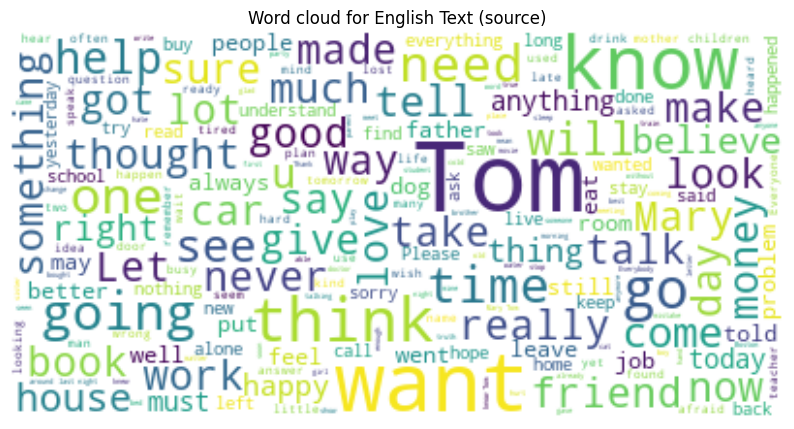

In [5]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(english_sentences))

plt.figure(figsize=(10, 8))
plt.title("Word cloud for English Text (source)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

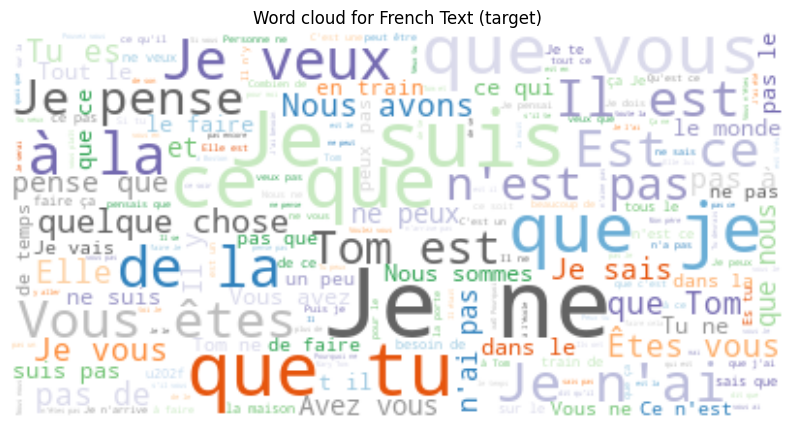

In [6]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white', colormap='tab20c')
wordcloud = wordcloud.generate(str(french_sentences))

plt.figure(figsize=(10, 8))
plt.title("Word cloud for French Text (target)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

**Box Plot**  
We want to visualize sentence lengths in a box plot to know which length will be used to pad/or clip the other sentences to it as all sequences should have the same size

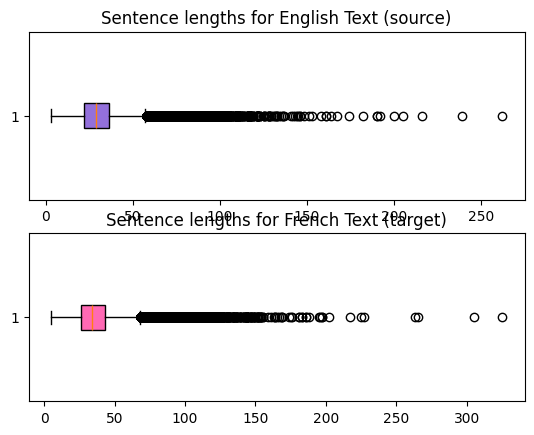

In [7]:
# visualizing box plot for source sentences
en_len = [len(english) for english in english_sentences]
plt.subplot(2, 1, 1)
#plt.figure(figsize=(8, 3))
plt.boxplot(en_len, vert=False, patch_artist=True, boxprops =dict(facecolor='mediumpurple'))
plt.title("Sentence lengths for English Text (source)")

# visualizing box plot for source sentences
fr_len = [len(french) for french in french_sentences]
plt.subplot(2, 1, 2)
#plt.figure(figsize=(8, 3))
plt.boxplot(fr_len, vert=False, patch_artist=True, boxprops =dict(facecolor='hotpink'))
plt.title("Sentence lengths for French Text (target)")

plt.show()

`Observation`  
We find that usually the french sentences are longer than the english 

### Text Preprocessing
Our dataset is mostly clean we just need to:
- Lowercase 
- Remove the punctuation (although sometimes it's important for the meaning but we'll remove this time for simplicity)
- Tokenize the words
- Add start of sentence -`sos` - and end of sentence - `eos` - tokens
- Add padding according to a predetermined `max_len`

We will also create an *English* and *French* vocabulary

In [8]:
def preprocess(sentences, max_len, num_words):
    """
    A method to apply preprocessing to a set of sentences
    
    Parameters:
    sentences (list or array-like sequence): senetnces to be cleaned and preprocessed
    max_len (int): maximum length of the sequences we will use in padding
    num_words (int): maximum number of words to keep in the vocabulary based on frequency

    Returns:
    clean_sentences (list or array-like sequence): set of tokenized and padded sequences
    vocab (dict): word to index dictionary containing the vocab and the respective index
    """
    # create a copy of the sentences to clean it
    clean_sentences = sentences.copy()

    # lowercase and sos and eos tokens
    for i in range(len(sentences)):
        clean_sentences[i] = "sos " + str(sentences[i]).lower() + " eos."
    
    # initialize the tokenizer - we will pass the punctuation we want to filter
    tokenizer = Tokenizer(num_words = num_words, filters = '!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
    # use the tokenizer to filter the text
    tokenizer.fit_on_texts(clean_sentences)
    # replace tokens with their respective index
    clean_sentences = tokenizer.texts_to_sequences(clean_sentences)

    # padding the sequences to match in length - add padding/ or truncate from the end
    clean_sentences = pad_sequences(clean_sentences, maxlen=max_len, padding='post', truncating='post')
    
    # create vocabulary
    vocab = tokenizer.word_index

    return clean_sentences, vocab, tokenizer

Now it's time to use the `preprocess()` function on each of the `french` and `english` sentences. But first we need to determine a few hyperparameters:
* `max_len`: based on the box plots of both languages we we will choose **30** which is a happy medium between the 2 languages
* `num_words`: any word among the top `num_words` in frequency will be added to the vocab, we will use **10 000** (a value often used in such task)

In [9]:
# define hyperparameters
max_len = 30
num_words = 10000
# preprocess both sets
english_data, word_index_en, tokenizer_en = preprocess(english_sentences[:10000], max_len, num_words)
french_data, word_index_fr, tokenizer_fr = preprocess(french_sentences[:10000], max_len, num_words)

# print the size of the vocab
print(f"The number of words in the English vocabulary: {len(word_index_en)}")
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

# look at sample from both
print(f"English Sample:\nOriginal sentence:\n{english_sentences[55]}\nTokenized sentence{english_data[55]}")
print(f"French Sample:\nOriginal sentence:\n{french_sentences[55]}\nTokenized sentence{french_data[55]}")

The number of words in the English vocabulary: 2852
The number of words in the French vocabulary: 5344
English Sample:
Original sentence:
No way!
Tokenized sentence[  1  38 355   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
French Sample:
Original sentence:
C'est pas possible !
Tokenized sentence[   1   10   11 1421    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Helper Functions
Before we dive into the model implementation we will create some functions that we will need inside the model.  
Looking at the structure of the encode-decoder transformer:  
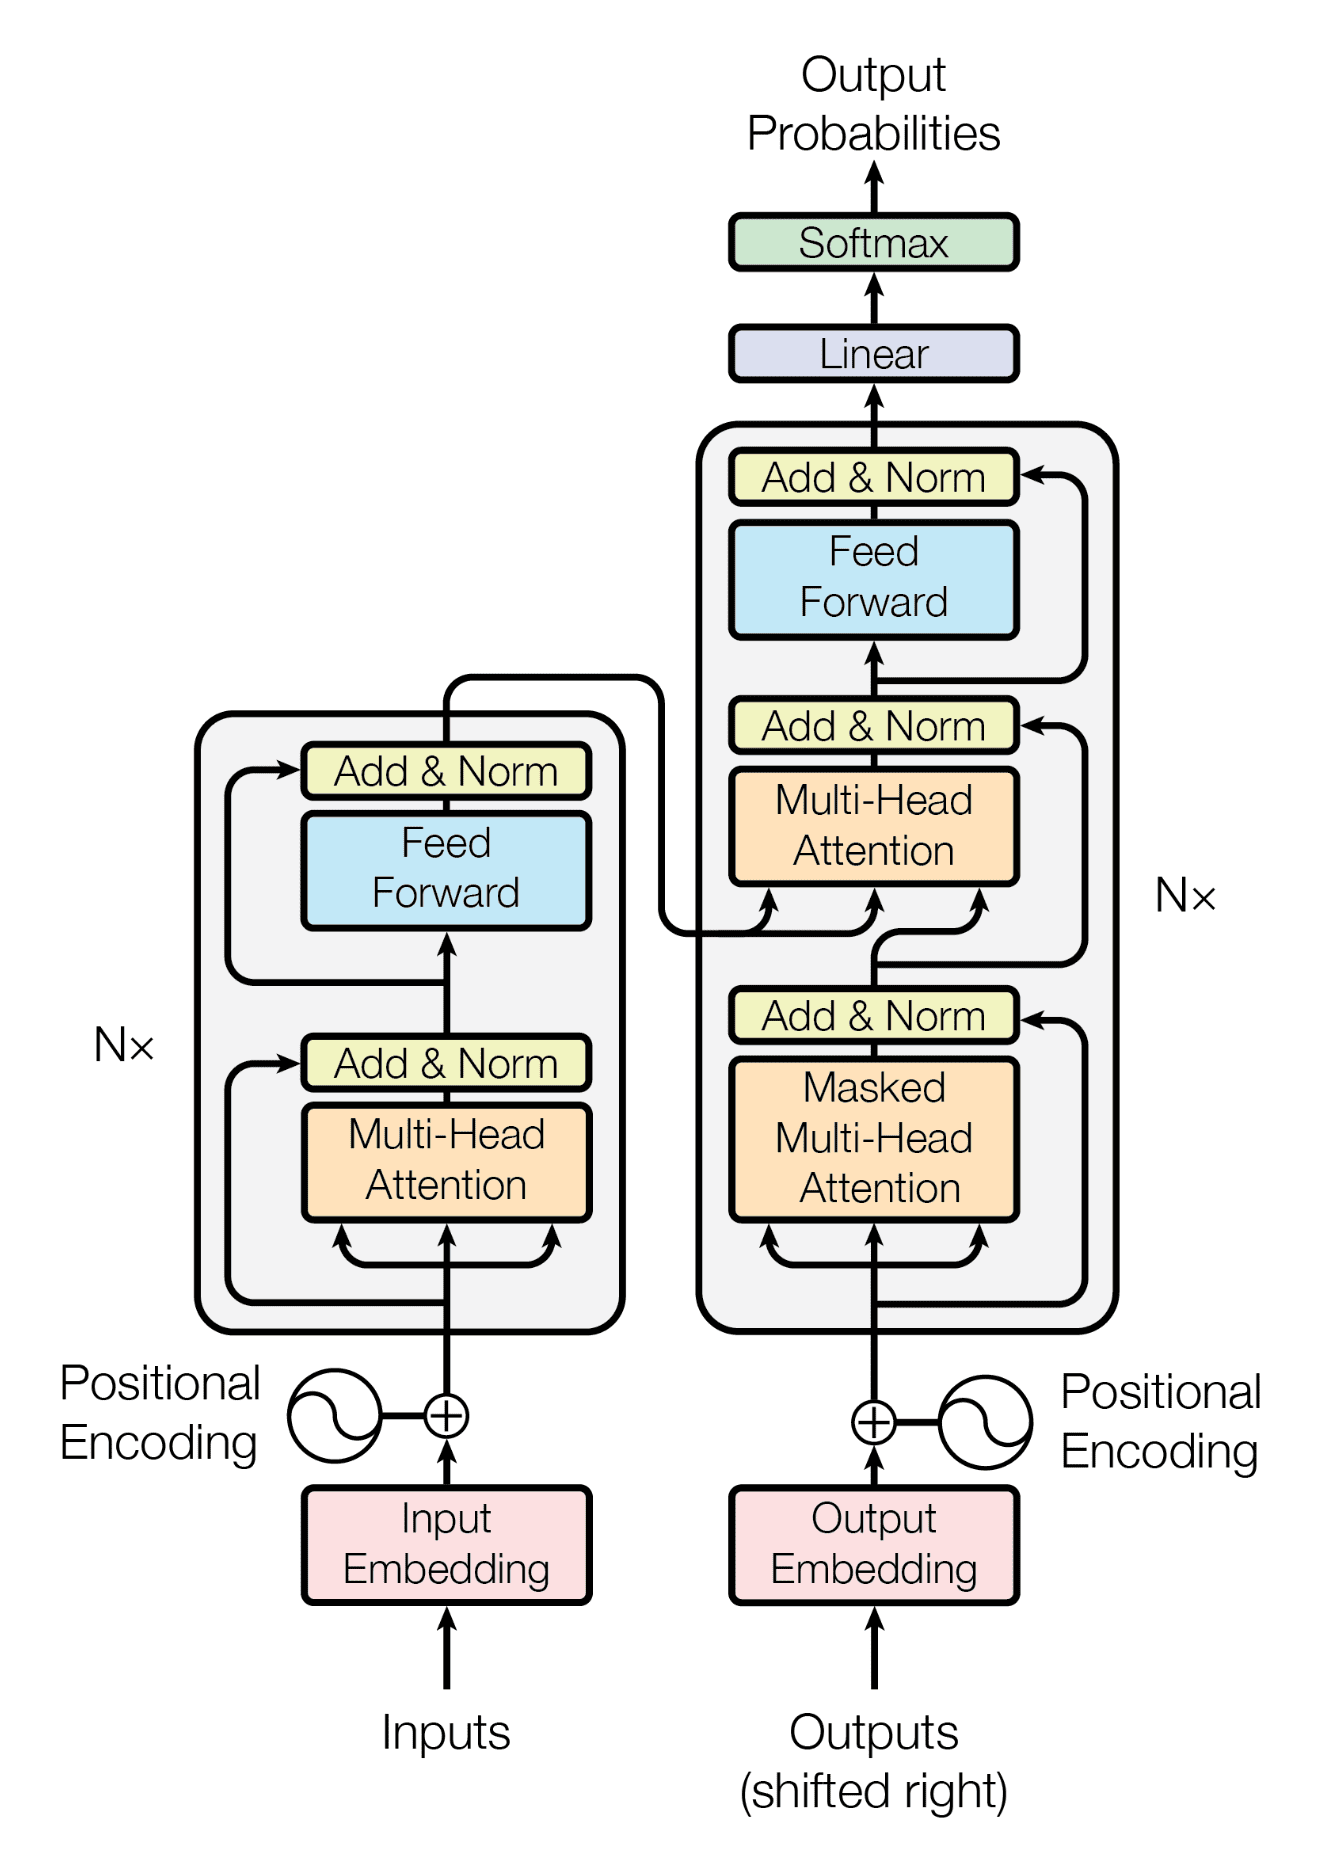

We find that we need:
### Positional Encoding
To encode information about the order of the sequence to the input embeddings entering the encoder, the formula as follows:  
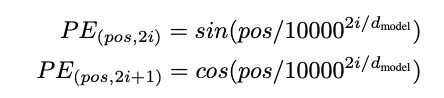


In [10]:
def get_angles(pos, i, embedding_dim):
    """
    Function to compute the angles for positional encoding.
    
    Returns the angle computed
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embedding_dim))
    return pos * angle_rates

def positional_encoding(position, embedding_dim):
    """
    Adds  positional encoding to the Embeddings to be fed to the Transformer model.
    
    Computes a sin and cos of the angles determined by the get_angles() function
    and adds the value computed to an axis of the embeddings.
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)
    
    # apply sin to even indices in the array. ie 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array. ie 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

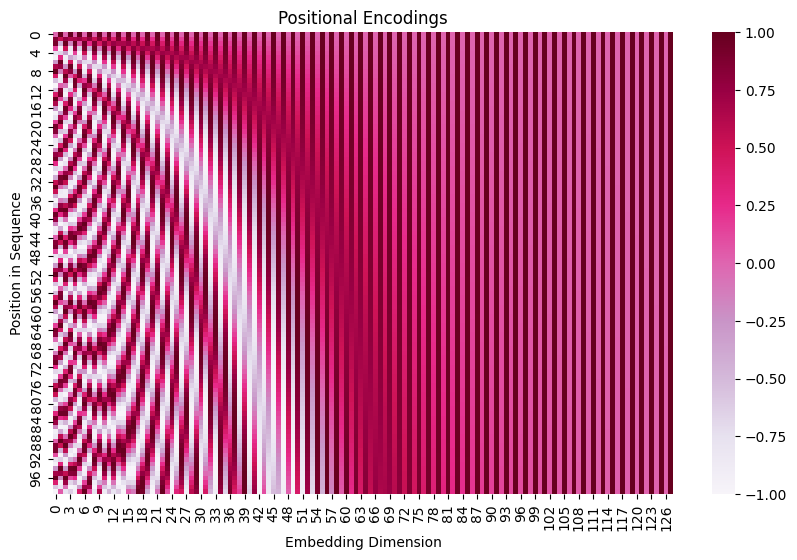

In [11]:
# visualizing some generated positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='PuRd')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

### Masking 
To account for the zeros added during padding we create a function that computes a boolean mask that flags the padded elements in the sequence. The mask is then used to set all padding values to a negative infinity value (-1e9) to disregard them in the softmax calculation.  
We also create a **look-ahead mask**:  
In training, you will have access to the complete correct output of your training example.   
But during inference, the model must generate output one token at a time based on its previous predictions. 

In [12]:
def create_padding_mask(seq):
    """
    Creates a padding mask for a given sequence.
    
    Args:
        seq (tensor): A tensor of shape (batch_size, seq_len) containing the sequence.
        
    Returns:
        A tensor of shape (batch_size, 1, 1, seq_len) containing a mask that is 1 where the sequence is padded, and 0 otherwise.
    """
    # Convert the sequence to a boolean tensor where True indicates a pad token (value 0).
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # Add an extra dimension to the mask to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    """
    Creates a look-ahead mask used during training the decoder of a transformer.

    Args:
        size (int): The size of the mask.

    Returns:
        tf.Tensor: A lower triangular matrix of shape (size, size) with ones on the diagonal
            and zeros below the diagonal.
    """
    # create a matrix with ones on the diagonal and zeros below the diagonal
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask

The `create_masks()` function is used to create the masks needed in our transformer model:
* Encoder mask: in the encoder block
* Combined mask: in the decoder block in the first attention block
* Decoder mask: in the decoder block in the 2nd attention block

In [13]:
def create_masks(inputs, targets):
    """
    Creates masks for the input sequence and target sequence.
    
    Args:
        inputs: Input sequence tensor.
        targets: Target sequence tensor.
    
    Returns:
        A tuple of three masks: the encoder padding mask, the combined mask used in the first attention block, 
        and the decoder padding mask used in the second attention block.
    """
    
    # Create the encoder padding mask.
    enc_padding_mask = create_padding_mask(inputs)
        
    # Create the decoder padding mask.
    dec_padding_mask = create_padding_mask(inputs)
    
    # Create the look ahead mask for the first attention block.
    # It is used to pad and mask future tokens in the tokens received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
    
    # Create the decoder target padding mask.
    dec_target_padding_mask = create_padding_mask(targets)
    
    # Combine the look ahead mask and decoder target padding mask for the first attention block.
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask 

## Model Implementation
### Multiheaded Attention
`Multi-head attention` works by dividing the `query, key, and value` matrices into smaller sub-matrices. Each of these sub-matrices focuses on a different part or "aspect" of the input. `Scaled dot-product` attention is then applied to each sub-matrix independently, producing multiple attention outputs.  
These outputs, each representing a different aspect, are `combined` (concatenated) and then `linearly transformed` (multiplied by a weight matrix) to create a final, unified attention output that incorporates all the different aspects of the input.

In [14]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Computes the scaled dot product attention weight for the query (q), key (k), and value (v) vectors. 
    The attention weight is a measure of how much focus should be given to each element in the sequence of values (v) 
    based on the corresponding element in the sequence of queries (q) and keys (k).
    
    Args:
    q: query vectors; shape (..., seq_len_q, depth)
    k: key vectors; shape  (..., seq_len_k, depth)
    v: value vectors; shape  (..., seq_len_v, depth_v)
    mask: (optional) mask to be applied to the attention weights
    Returns:
    output: The output of the scaled dot product attention computation; shape   (..., seq_len_q, depth_v)
    attention_weights: The attention weights
    """
    # Compute dot product of query and key vectors
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # Compute the square root of the depth of the key vectors
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    # Compute scaled attention logits by dividing dot product by scaled dk
    scaled_attention_logits = matmul_qk / scaled_dk
    
    # Apply mask to the attention logits (if mask is not None)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # Apply softmax to the scaled attention logits to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # Compute the weighted sum of the value vectors using the attention weights
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

We have **MultiHeadAttention** class which represents the laayer that implements the attention mechanism for the Transformer.  
It splits the input into multiple heads, computes scaled dot-product attention for each head, and then concatenates the output of the heads and passes it through a dense layer.

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, key_dim, num_heads, dropout_rate=0.0):
        """
        Initializes the MultiHeadAttention layer.
    
        Args:
            key_dim (int): The dimensionality of the key space.
            num_heads (int): The number of attention heads.
            dropout (float): The dropout rate to apply after the dense layer.
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        #  ensure  that the dimension of the embedding can be evenly split across attention heads
        assert key_dim % num_heads == 0 
        self.depth = self.key_dim // self.num_heads
        # dense layers to project the input into queries, keys and values
        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)
    
        # dropout layer
        self.dropout = Dropout(dropout_rate)
    
        # dense layer to project the output of the attention heads
        self.dense = Dense(key_dim)
        
    def split_heads(self, x, batch_size):
        """
        Splits the last dimension of the tensor into (num_heads, depth).
        Transposes the result such that the shape is (batch_size, num_heads, seq_len, depth).
    
        Args:
            x (tensor): The tensor to be split.
            batch_size (int): The size of the batch.
    
        Returns:
            tensor: The tensor with the last dimension split into (num_heads, depth) and transposed.
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask=None):
        """
        Applies the multi-head attention mechanism to the inputs.
    
        Args:
            v (tensor): The value tensor of shape (batch_size, seq_len_v, key_dim).
            k (tensor): The key tensor of shape (batch_size, seq_len_k, key_dim).
            q (tensor): The query tensor of shape (batch_size, seq_len_q, key_dim).
            mask (tensor, optional): The mask tensor of shape (batch_size, seq_len_q, seq_len_k).
                                     Defaults to None.
    
        Returns:
            tensor: The output tensor of shape (batch_size, seq_len_q, key_dim).
            tensor: The attention weights tensor of shape (batch_size, num_heads, seq_len_q, seq_len_k).
        """
        batch_size = tf.shape(q)[0]
        
        # Dense on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
                
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # split the queries, keys and values into multiple heads
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)
        
        return output, attention_weights

### Fully Connected Neural Network
A FCNN containing a single hidden layer with `ReLU` activation and outputs a matrix of the same dimension as the **embedding_dim**, we use that layer to introduce non-linearity to the model and for it to learn better

In [16]:
def FeedForward(embedding_dim, fully_connected_dim):
    """Create a fully connected feedforward neural network.
    
    Args:
        embedding_dim (int): Dimensionality of the embedding output from the transformer layer.
        fully_connected_dim (int): Number of neurons in the fully connected layers.
    
    Returns:
        tf.keras.Sequential: A fully connected feedforward neural network with the specified architecture.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])
    return model

### Encoder
The Encoder will consist of several Encoder layers stacked on top of each other to create our bock.

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """Initializes the encoder layer
        
        Args: 
            embedding_dim: The dimensionality of the input and output of this layer
            num_heads: The number of attention heads to use in the multi-head attention layer
            fully_connected_dim: The dimensionality of the hidden layer in the feedforward network
            dropout_rate: The rate of dropout to apply to the output of this layer during training
            
        Returns:
            A new instance of the EncoderLayer class
        """
        super(EncoderLayer, self).__init__()
        
        # Multi-head self-attention mechanism
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout = Dropout(dropout_rate)
        
        # Feedforward network
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
    def call(self, x, training, mask=None):
        """Applies the encoder layer to the input tensor
        
        Args:
            x: The input tensor to the encoder layer
            training: A boolean indicating whether the model is in training mode
            mask: A tensor representing the mask to apply to the attention mechanism
        Returns:
            The output of the encoder layer after applying the multi-head attention and feedforward network
        """
        
        # Apply multi-head self-attention mechanism to input tensor
        attn_output, _ = self.mha(x, x, x, mask)
        
        # Apply first layer normalization and add residual connection
        out1 = self.layernorm1(attn_output + x)
        
        # Apply feedforward network to output of first layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        
        # Apply second layer normalization and add residual connection
        out2 = self.layernorm2(ffn_output + out1)
        
        return out2

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        """
        Initializes the Encoder layer of the Transformer model.
        
        Args:
            num_layers (int): Number of EncoderLayers to stack.
            embedding_dim (int): Dimensionality of the token embedding space.
            num_heads (int): Number of attention heads to use in MultiHeadAttention layers.
            fully_connected_dim (int): Dimensionality of the fully connected layer in the EncoderLayer.
            input_vocab_size (int): Size of the input vocabulary.
            maximum_position_encoding (int): Maximum length of input sequences for positional encoding.
            dropout_rate (float): Probability of dropping out units during training.

        """
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # Embedding layer
        self.embedding = Embedding(input_vocab_size, embedding_dim)
        
        # Positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        
        # Encoder layers
        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]
        
        # Dropout layer
        self.dropout = Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):
        """
        Call function for the Encoder layer.
        
        Args:
            inputs: tensor of shape (batch_size, sequence_length) representing input sequences
            training: boolean indicating if the model is in training mode
            mask: tensor of shape (batch_size, sequence_length) representing the mask to apply to the input sequence

        Returns:
            A tensor of shape (batch_size, sequence_length, embedding_dim) representing the encoded sequence
        """

        # Get the sequence length
        seq_len = tf.shape(inputs)[1]

        # Embed the input sequence
        inputs = self.embedding(inputs)

        # Scale the embeddings by sqrt(embedding_dim)
        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encodings to the input sequence
        inputs += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input sequence
        inputs = self.dropout(inputs, training=training)

        # Pass the input sequence through the encoder layers
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training=training, mask=mask)

        # Return the encoded sequence
        return inputs


### Dencoder
The Dencoder will consist of several Dencoder layers stacked on top of each other to create our bock.

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """
        Initializes a single decoder layer of the transformer model.
        
        Args:
        embedding_dim: The dimension of the embedding space.
        num_heads: The number of attention heads to use.
        fully_connected_dim: The dimension of the feedforward network.
        rate: The dropout rate for regularization.
        """
        super(DecoderLayer, self).__init__()
        
        # Instantiate two instances of MultiHeadAttention.
        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Instantiate a fully connected feedforward network.
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
        # Instantiate three layer normalization layers with epsilon=1e-6.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        # Instantiate a dropout layer for regularization.
        self.dropout3 = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        """
        Forward pass through the decoder layer.
        
        Args:
        x: The input to the decoder layer, a query vector.
        enc_output: The output from the top layer of the encoder, a set of attention vectors k and v.
        training: Whether to apply dropout regularization.
        look_ahead_mask: The mask to apply to the input sequence so that it can't look ahead to future positions.
        padding_mask: The mask to apply to the input sequence to ignore padding tokens.
        
        Returns:
        The output from the decoder layer, a tensor with the same shape as the input.
        The attention weights from the first multi-head attention layer.
        The attention weights from the second multi-head attention layer.
        """
        
        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        # Add the original input to the output of the attention layer and apply layer normalization.
        out1 = self.layernorm1(attn1 + x) 
        
        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        
        # Add the output from the first layer to the output of the second layer and apply layer normalization.
        out2 = self.layernorm2(attn2 + out1)
        
        # Apply the feedforward network to the output of the second layer and apply dropout regularization.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Add the output from the second layer to the output of the feedforward network and apply layer normalization.
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2  

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        """
        Initializes the Decoder object.
        
        Args:
            num_layers (int): The number of Decoder layers.
            embedding_dim (int): The size of the embedding dimension.
            num_heads (int): The number of heads in the MultiHeadAttention layer.
            fully_connected_dim (int): The number of units in the feedforward network.
            target_vocab_size (int): The number of words in the target vocabulary.
            maximum_position_encoding (int): The maximum length of a sequence.
            dropout_rate (float): The rate at which to apply dropout.
        """
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # create layers
        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Executes the Decoder.

        Args:
            x (tf.Tensor): The input to the Decoder.
            enc_output (tf.Tensor): The output from the Encoder.
            training (bool): Whether the Decoder is in training mode.
            look_ahead_mask (tf.Tensor): The mask for self-attention in the MultiHeadAttention layer.
            padding_mask (tf.Tensor): The mask for padding in the MultiHeadAttention layer.

        Returns:
            tf.Tensor: The output from the Decoder.
            dict: A dictionary of attention weights.
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # apply each layer of the decoder
        for i in range(self.num_layers):
            # pass through decoder layer i
            x, block1, block2 = self.dec_layers[i](x, enc_output = enc_output, training = training, look_ahead_mask = look_ahead_mask, padding_mask = padding_mask)

            # record attention weights for block1 and block2
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2

        return x, attention_weights

### Transformer

**Core Components:**  
  
***Encoder:***
* Processes the input sequence.
* Generates a sequence of hidden representations.
  
***Decoder***:
* Utilizes the encoder's hidden representations.
* Generates the output sequence.  

    
**Building Blocks:** Both encoder and decoder layers consist of:  
* ***Multi-Headed Self-Attention:*** Enables the model to weigh the importance of different parts of the input sequence.
* ***Point-Wise Feed-Forward Neural Networks:*** Apply non-linear transformations to the attention outputs.

In [42]:
class Transformer(tf.keras.Model):
    """
    A Transformer model that takes in an input and target sequence and outputs a final prediction.

    Args:
        num_layers (int): Number of layers in the Encoder and Decoder.
        embedding_dim (int): Dimensionality of the embedding layer.
        num_heads (int): Number of attention heads used in the Transformer.
        fully_connected_dim (int): Dimensionality of the fully connected layer in the Encoder and Decoder.
        input_vocab_size (int): Size of the input vocabulary.
        target_vocab_size (int): Size of the target vocabulary.
        max_positional_encoding_input (int): Maximum length of the input sequence.
        max_positional_encoding_target (int): Maximum length of the target sequence.
        dropout_rate (float, optional): Dropout rate used in the Encoder and Decoder layers. Defaults to 0.1.
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout_rate=0.1):
        super(Transformer, self).__init__()
        # Initialize the Encoder and Decoder layers
        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, max_positional_encoding_target, dropout_rate)
        
        # Add a final dense layer to make the final prediction
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Perform a forward pass through the Transformer model.

        Args:
            inp (tf.Tensor): Input sequence tensor with shape (batch_size, input_seq_len).
            tar (tf.Tensor): Target sequence tensor with shape (batch_size, target_seq_len).
            training (bool): Whether the model is being trained or not.
            enc_padding_mask (tf.Tensor): Padding mask for the Encoder with shape (batch_size, 1, 1, input_seq_len).
            look_ahead_mask (tf.Tensor): Mask to prevent the Decoder from looking ahead in the target sequence with shape (batch_size, 1, target_seq_len, target_seq_len).
            dec_padding_mask (tf.Tensor): Padding mask for the Decoder with shape (batch_size, 1, 1, target_seq_len).

        Returns:
            tuple: A tuple containing the final output of the model and the attention weights of the Decoder.
        """
        # Pass the input sequence through the Encoder
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # Corrected parameter name
        
        # Pass the target sequence and the output of the Encoder through the Decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask
        )
        
        # Pass the output of the Decoder through the final dense layer to get the final prediction
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

## Training the model
### Initializing Hyperparameters

In [43]:
# initialize hyperparameters
embedding_dim = 256  # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 512  # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 4  # number of Transformer blocks in the encoder and decoder stacks
num_heads = 8  # number of heads in the multi-head attention mechanism
dropout_rate = 0.1  # dropout rate for regularization

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(word_index_en) + 1 # add 1 for oov 
target_vocab_size = len(word_index_fr) + 1  # add 1 for oov

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size  # maximum positional encoding value for input sequence
max_positional_encoding_target = target_vocab_size  # maximum positional encoding value for target sequence

# Set the number of epochs and batch size for training
EPOCHS = 10
batch_size = 64

### Learning Rate Scheduler
A custom class to schedule the learning rate decay - where the learning rate gradually decreases the closer we get to convergence - in each learning step to adjust the learning rate according to how much the model learned and still needs to learn

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    A custom learning rate schedule that uses a combination of
    a square root inverse decay and a warmup schedule.

    Args:
        embedding_dim (int): The dimension of the embedding.
        warmup_steps (int): The number of steps used for warmup.

    Returns:
        float: The learning rate value at a given step.
    """
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        """
        Compute the learning rate value for a given step using
        a combination of square root inverse decay and warmup.

        Args:
            step (int): The current step number.

        Returns:
            float: The learning rate value at the current step.
        """
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

### Optimizer and Loss
- `Adam` optimizer with the customized learning scheduler
- `SparseCategoricalCrossEntropy` is the loss function
- `SparseCategoricalAccuracy` is the evaluation metric used during training and testing, however we will use `BLEU` score as well during inference to evaluate the quality of the predictions

In [45]:
# Create an instance of the Transformer model
transformer = Transformer(num_layers, embedding_dim, num_heads,
                           fully_connected_dim, input_vocab_size, target_vocab_size, 
                           max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(true_values, predictions):
    """
    Calculate the loss value for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The loss value for the given target sequence.
    """
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Compute the loss value using the loss object
    loss_ = loss_object(true_values, predictions)

    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # Calculate the mean loss value
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_values, predictions):
    """
    Calculate the accuracy for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The accuracy value for the given target sequence.
    """
    # Compute the accuracies using the true and predicted target sequences
    accuracies = tf.equal(true_values, tf.argmax(predictions, axis=2))

    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Apply the mask to exclude the padding tokens from the accuracies
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Calculate the mean accuracy value
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define the training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### Training Function and Training Loop

In [46]:
# the train function
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, max_len), dtype=tf.int64),
    tf.TensorSpec(shape=(batch_size,max_len), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(encoder_input, target):
    """
    Function to perform a single training step.

    Args:
    encoder_input (tf.Tensor): The input tensor for the encoder.
    target (tf.Tensor): The target tensor for the decoder.

    Returns:
    None.
    """

    # Slice the target tensor to get the input for the decoder
    decoder_input = target[:, :-1]

    # Slice the target tensor to get the expected output of the decoder
    expected_output = target[:, 1:]

    # Create masks for the encoder input, decoder input and the padding
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # Perform a forward pass through the model
    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, decoder_input, training=True, enc_padding_mask=enc_padding_mask, look_ahead_mask=combined_mask, dec_padding_mask=dec_padding_mask)

        # Calculate the loss between the predicted output and the expected output
        loss = loss_function(expected_output, predictions)

    # Calculate gradients and update the model parameters
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update the training loss and accuracy metrics
    train_loss(loss)
    train_accuracy(expected_output, predictions)

In [47]:
for epoch in range(1, EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    current_batch_index = 0

    # iterate through the dataset in batches of batch_size
    for i in range(int(len(english_data)/batch_size)):
        # get the input and target batch
        input_batch = tf.convert_to_tensor(np.array(english_data[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)
        output_batch = tf.convert_to_tensor(np.array(french_data[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)

        input_batch = tf.minimum(input_batch, input_vocab_size - 1)  # Clamp values within valid range
        output_batch = tf.minimum(output_batch, target_vocab_size - 1)  # Clamp values within valid range
        
        current_batch_index = current_batch_index + batch_size
        # call the train_step function to train the model using the current batch
        train_step(input_batch, output_batch)

    # print the epoch loss and accuracy after iterating through the dataset
    print (f'Epoch {epoch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}') 

Epoch 1 Loss 5.5049 Accuracy 0.7264
Epoch 2 Loss 2.4180 Accuracy 0.8463
Epoch 3 Loss 1.0405 Accuracy 0.8755
Epoch 4 Loss 0.8180 Accuracy 0.8824
Epoch 5 Loss 0.7476 Accuracy 0.8900
Epoch 6 Loss 0.6930 Accuracy 0.8951
Epoch 7 Loss 0.6533 Accuracy 0.9009
Epoch 8 Loss 0.6105 Accuracy 0.9049
Epoch 9 Loss 0.5827 Accuracy 0.9075
Epoch 10 Loss 0.5567 Accuracy 0.9090
